# Preliminaries

### Import statements

In [1]:
import os
import pickle
import re
import numpy as np
import math
from collections import Counter
from cltk import NLP
from dicesapi import DicesAPI
from dicesapi.text import CtsAPI, Passage
from dicesapi.jupyter import NotebookPBar
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from scipy.stats import f_oneway, tukey_hsd
from matplotlib import pyplot as plt

# custom code for this notebook
#   - see seneca_experiment.py
from seneca_experiment import SenecaSpeech, getTags, tagtype, deserializeLists

### Connections to remote databases, local files

In [2]:
# Seneca text
seneca_text_file = os.path.join('data', 'seneca_speeches.txt')

# remote endpoints
api = DicesAPI(logfile='dices.log')
cts = CtsAPI(dices_api=api)

In addition to the hand-curated input from Bernhard for Seneca's speeches, I'm using local csv files to store the NLP annotations for the tokenized speeches, since parsing all that text takes some time. 

**NB**: Delete the csv files to rerun everything from scratch. This might run prohibitively slowly on binder, but it only takes half an hour or so on my old laptop. You could try just deleting the Seneca cache to see the parsing in operation on a smaller speech set.

In [3]:
# cache files
cache_seneca = os.path.join('data', 'seneca_tokens.csv')
cache_flavians = os.path.join('data', 'flavian_tokens.csv')

# Part 1: Seneca

### Use cache if it's present

If the CSV files with all the parsed tokens is here, we just use that and skip the next several steps.

In [4]:
if os.path.exists(cache_seneca):
    sen_tokens = pd.read_csv(cache_seneca)
    print(f'Loaded {len(sen_tokens)} records from {cache_seneca}')
    SKIP_SENECA = True
else:
    SKIP_SENECA = False

Loaded 5599 records from data/seneca_tokens.csv


### Read Bernhard's text and parse into speech-like objects

In [5]:
if not SKIP_SENECA:
    with open(seneca_text_file) as f:
        text = f.read()
        if text:
            sen_texts = re.split('\n\n+', text)

    # how many speeches did we get?
    print(f'Loaded {len(sen_texts)} speeches from {seneca_text_file}')

In [6]:
if not SKIP_SENECA:
    sen_speeches = [SenecaSpeech(id=i, text=s) for i, s in enumerate(sen_texts)]

### Run CLTK's NLP pipeline

In [7]:
if not SKIP_SENECA:
    for s in sen_speeches:
        print (s, '...', end='')

        if (not hasattr(s.passage, 'cltk')) or s.passage.cltk is None:
            s.passage.runCltkPipeline(remove_punct=True)
        if s.passage.cltk is not None:
            print('OK')
        else:
            print('fail')

### Convert to tabular form

`sen_tokens` is a table with one row per token. It includes basic details on the passage as well as universal part of speech label and lemma.

In [8]:
if not SKIP_SENECA:
    sen_tokens = pd.DataFrame(dict(
        id = s.id,
        auth = 'Seneca',
        tags = 'trag',
        l_fi = s.l_fi,
        l_la = s.l_la,
        spkr = s.spkr,
        lem = w.lemma,
        pos = w.upos,
    ) for s in sen_speeches for w in s.passage.cltk)
    
    sen_tokens.to_csv(cache_seneca, index=False)
    print(f'Writing {len(sen_tokens)} records to {cache_seneca}')

### Example of tabular data

`sen_tokens` is a table with one row per token. It includes basic details on the passage as well as universal part of speech label and lemma. This is what is stored in the cache file.

In [9]:
sen_tokens

,id,auth,tags,l_fi,l_la,spkr,lem,pos
0,0,Seneca,trag,1,278,Iuno,Soror,NOUN
1,0,Seneca,trag,1,278,Iuno,Tonantis,VERB
2,0,Seneca,trag,1,278,Iuno,(,PUNCT
3,0,Seneca,trag,1,278,Iuno,hic,PRON
4,0,Seneca,trag,1,278,Iuno,enim,ADV
...,...,...,...,...,...,...,...,...
5594,52,Seneca,trag,1341,1344,Theseus,innocens,ADJ
5595,52,Seneca,trag,1341,1344,Theseus,terra,NOUN
5596,52,Seneca,trag,1341,1344,Theseus,qui,PRON
5597,52,Seneca,trag,1341,1344,Theseus,super,NOUN


### Shape of the data

#### Basics

In [10]:
print(f'There are {sen_tokens.id.nunique()} speeches, totalling {len(sen_tokens)} tokens')

There are 53 speeches, totalling 5599 tokens


#### Speech length distribution

How many long speeches? How many short speeches?

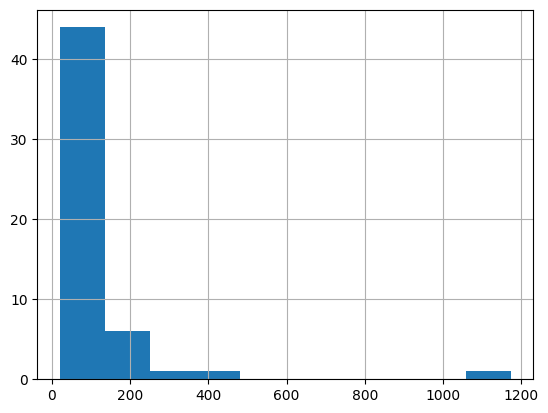

In [11]:
sen_tokens.groupby('id').size().hist()
plt.show()

One outlier is making it hard to see fine details---let's zoom in on the left part of the graph:

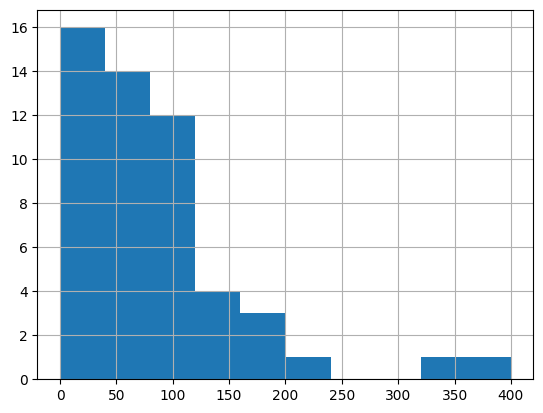

In [12]:
sen_tokens.groupby('id').size().hist(range=[0,400])
plt.show()

Most of these speeches are pretty short... about 100 words or fewer.

### Part of speech counts

How much does Seneca use each of the parts of speech (according to CLTK's classification)?

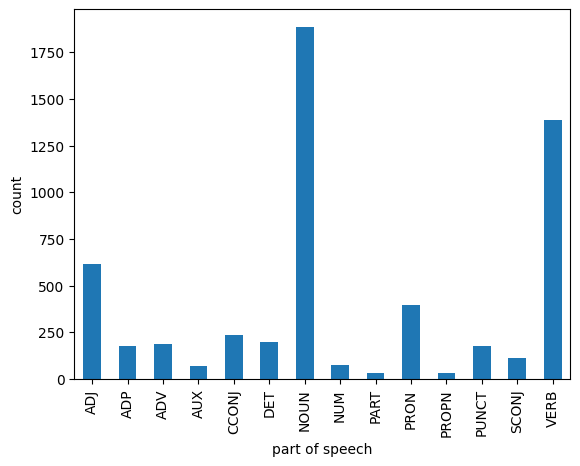

In [13]:
ax = sen_tokens.groupby('pos').size().plot.bar()
ax.set_xlabel('part of speech')
ax.set_ylabel('count')
plt.show()

**Two important notes:**

1. CLTK's part of speech tags don't include interjections here! I don't know why not... I'm fairly confident that I've seen results on Greek texts that do include interjections. But for whatever reason, any words that we consider interjections in this text are being labelled as other parts of speech.

2. Even though I tried to filter out punctuation before parsing (it generally improves the lemmatization), CLTK is labelling some tokens as `PUNCT`. These seem mostly to be actual punctuation marks that my initial efforts missed.

### Tabulate POS counts per speech

This table tallies part of speech tags by speech. Each row is one speech. Speeches with more words will have higher counts.

In [14]:
sen_pos = pd.crosstab(sen_tokens.id, sen_tokens.pos)
sen_pos

pos,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB
id,,,,,,,,,,,,,,
0,125,38,41,18,55,26,406,6,7,81,8,30,20,312
1,19,3,4,3,13,16,49,1,0,19,1,1,3,47
2,23,5,3,2,8,6,48,2,3,10,0,3,4,41
3,11,3,3,1,3,1,23,1,0,3,0,1,1,23
4,18,5,4,1,5,3,61,3,0,13,2,7,4,33
5,6,5,1,1,6,5,36,1,3,6,0,3,4,32
6,4,2,1,0,1,4,17,1,1,3,0,2,0,13
7,5,4,1,1,3,1,17,1,0,3,1,1,0,13
8,5,1,1,0,0,0,11,1,1,4,1,2,1,9


### Same, but normalized for speech length

This is the same table, but we divide each row by the total number of tokens, making long speeches and short speeches more comparable.

In [15]:
sen_norm = pd.crosstab(sen_tokens.id, sen_tokens.pos, normalize='index')
sen_norm

pos,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB
id,,,,,,,,,,,,,,
0,0.106564,0.032396,0.034953,0.015345,0.046888,0.022165,0.346121,0.005115,0.005968,0.069054,0.006820,0.025575,0.017050,0.265985
1,0.106145,0.016760,0.022346,0.016760,0.072626,0.089385,0.273743,0.005587,0.000000,0.106145,0.005587,0.005587,0.016760,0.262570
2,0.145570,0.031646,0.018987,0.012658,0.050633,0.037975,0.303797,0.012658,0.018987,0.063291,0.000000,0.018987,0.025316,0.259494
3,0.148649,0.040541,0.040541,0.013514,0.040541,0.013514,0.310811,0.013514,0.000000,0.040541,0.000000,0.013514,0.013514,0.310811
4,0.113208,0.031447,0.025157,0.006289,0.031447,0.018868,0.383648,0.018868,0.000000,0.081761,0.012579,0.044025,0.025157,0.207547
5,0.055046,0.045872,0.009174,0.009174,0.055046,0.045872,0.330275,0.009174,0.027523,0.055046,0.000000,0.027523,0.036697,0.293578
6,0.081633,0.040816,0.020408,0.000000,0.020408,0.081633,0.346939,0.020408,0.020408,0.061224,0.000000,0.040816,0.000000,0.265306
7,0.098039,0.078431,0.019608,0.019608,0.058824,0.019608,0.333333,0.019608,0.000000,0.058824,0.019608,0.019608,0.000000,0.254902
8,0.135135,0.027027,0.027027,0.000000,0.000000,0.000000,0.297297,0.027027,0.027027,0.108108,0.027027,0.054054,0.027027,0.243243


### Comparing speeches

Does part of speech use tell us anything interesting about the text? Let's try a simple comparison: how often does each character use adjectives?

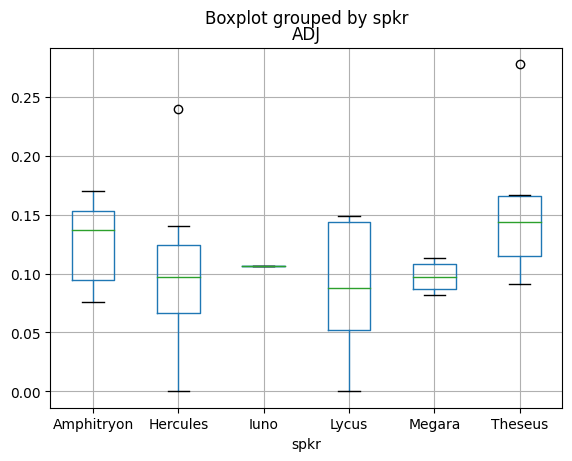

In [16]:
sen_labels = sen_tokens.groupby('id').agg({'auth':'first', 'spkr':'first', 'tags':'first'})
pd.concat([sen_norm, sen_labels], axis=1).boxplot(column='ADJ', by='spkr')
plt.show()

There's a lot of overlap, but it looks like Theseus uses adjectives more than Hercules, for example. Let's look at the two distributions in more detail:

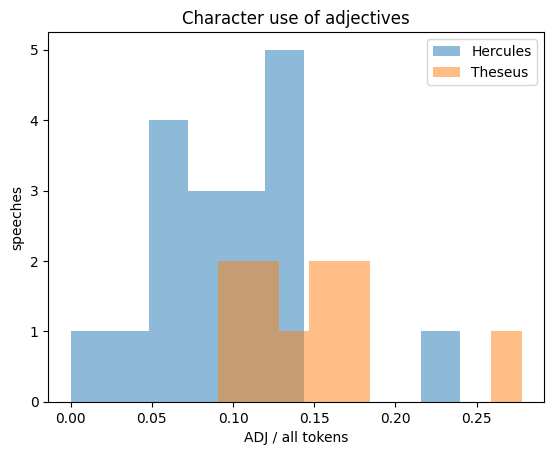

In [17]:
fig, ax = plt.subplots()
ax.hist(sen_norm.loc[sen_labels.spkr=='Hercules']['ADJ'], alpha=0.5, label='Hercules')
ax.hist(sen_norm.loc[sen_labels.spkr=='Theseus']['ADJ'], alpha=0.5, label='Theseus')
ax.legend()
ax.set_title('Character use of adjectives')
ax.set_xlabel('ADJ / all tokens')
ax.set_ylabel('speeches')
plt.show()

The two peaks are definitely different, but we also see how patchy the data is, particularly for Theseus.
At the end of the day, there aren't a lot of speeches here, but this is at least a sign that we might look profitably look more closely at Theseus' use of adjectives.

**But on the other hand...**

Hercules uses more subordinating conjunctions than Theseus. So it's not just that he's a less-sophisticated speaker...

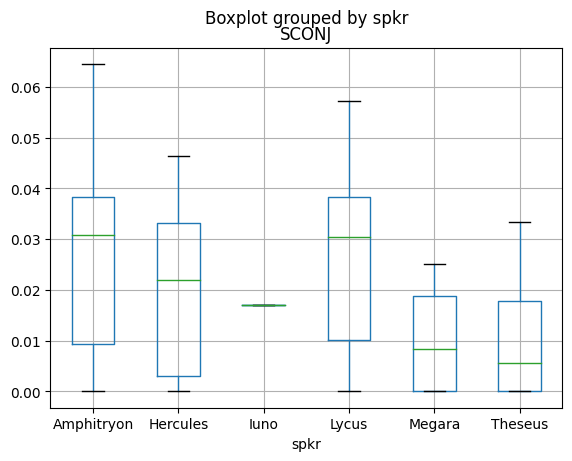

In [18]:
pd.concat([sen_norm, sen_labels], axis=1).boxplot(column='SCONJ', by='spkr')
plt.show()

# Part 2: Flavians

### Use cache if it's present

If the CSV files with all the parsed tokens is here, we just use that and skip the next several steps.

In [19]:
if os.path.exists(cache_flavians):
    flav_tokens = pd.read_csv(cache_flavians)
    flav_tokens.tags = flav_tokens.tags.apply(deserializeLists)
    flav_tokens.spkr = flav_tokens.spkr.apply(deserializeLists)    
    print(f'Loaded {len(flav_tokens)} records from {cache_flavians}')
    SKIP_FLAV = True
else:
    SKIP_FLAV = False

Loaded 68315 records from data/flavian_tokens.csv


### Retrieve the speeches from DICES

In [20]:
if not SKIP_FLAV:
    flav_speeches = sorted(
                    api.getSpeeches(author_name='Statius') + \
                    api.getSpeeches(author_name='Silius') + \
                    api.getSpeeches(author_name='Valerius Flaccus'))
    print(f'Retrieved {len(flav_speeches)} speeches')

### Retrieve text from Perseus

In [21]:
if not SKIP_FLAV:
    pbar = NotebookPBar(max=len(flav_speeches))

    for i, s in enumerate(flav_speeches):
        if (not hasattr(s, 'passage')) or s.passage == None:
            s.passage = cts.getPassage(s)
            if s.passage is None:
                print(f'failed: {s}')
        pbar.update(i)

### Parse with CLTK

In [22]:
if not SKIP_FLAV:
    pbar = NotebookPBar(max=len(flav_speeches))

    for i, s in enumerate(flav_speeches):
        if s.passage is not None:
            if (not hasattr(s.passage, 'cltk')) or s.passage.cltk == None:
                s.passage.runCltkPipeline(remove_punct=True)
        pbar.update(i)

### Generate a bit table of tokens

As with `sen_tokens` above, this has one row per token.

**Note:** Both the `spkr` and `tags` columns can theoretically contain multiple values, since it's pretty common for speeches to be tagged with multiple speech types, and on rare occasions a single speech has two speakers.

In [23]:
if not SKIP_FLAV:
    flav_tokens = []
    for s in flav_speeches:
        if s.passage is not None and s.passage.cltk is not None:
            for w in s.passage.cltk:
                flav_tokens.append(dict(
                    id = s.id,
                    auth = s.author.name,
                    work = s.work.title,
                    l_fi = s.l_fi,
                    l_la = s.l_la,
                    tags = getTags(s),
                    spkr = [spkr.name for spkr in s.spkr],
                    lem = w.lemma,
                    pos = w.upos,
                ))
    flav_tokens = pd.DataFrame(flav_tokens)
    
    flav_tokens.to_csv(cache_flavians, index=False)
    print(f'Writing {len(flav_tokens)} records to {cache_flavians}')

In [24]:
flav_tokens

,id,auth,work,l_fi,l_la,tags,spkr,lem,pos
0,2692,Silius,Punica,1.420,1.540,"[ora, exh, nar]",[Juno],Intulerit,VERB
1,2692,Silius,Punica,1.420,1.540,"[ora, exh, nar]",[Juno],Latio,NOUN
2,2692,Silius,Punica,1.420,1.540,"[ora, exh, nar]",[Juno],sperno,VERB
3,2692,Silius,Punica,1.420,1.540,"[ora, exh, nar]",[Juno],ego,PRON
4,2692,Silius,Punica,1.420,1.540,"[ora, exh, nar]",[Juno],Troius,NOUN
...,...,...,...,...,...,...,...,...,...
68310,2691,Valerius Flaccus,Argonautica,8.467,8.467,"[res, per]",[Jason],?,PUNCT
68311,2691,Valerius Flaccus,Argonautica,8.467,8.467,"[res, per]",[Jason],ego,PRON
68312,2691,Valerius Flaccus,Argonautica,8.467,8.467,"[res, per]",[Jason],talis,DET
68313,2691,Valerius Flaccus,Argonautica,8.467,8.467,"[res, per]",[Jason],velle,VERB


### Tag counts

#### How many tokens are there for each tag type?

Note that any time we're comparing between speech types, we need to break down the multiple values in the `tags` column. That means creating multiple copies of these rows, one for each tag. This is done with the pandas `explode` method.

Note that in tables comparing types like this, the column totals aren't reflective of true number of speeches/tokens in the corpus, since some speeches are considered more than once.

In [25]:
tag_count = flav_tokens[['id','tags']].explode('tags').groupby('tags').agg(
    tokens = pd.NamedAgg(column='id', aggfunc='count'),
    speeches = pd.NamedAgg(column='id', aggfunc='nunique'),
).sort_values(by='speeches', ascending=False)
tag_count['label'] = [tagtype[t] for t in tag_count.index]
tag_count

,tokens,speeches,label
tags,,,
del,12014,115,Deliberation
exh,7313,106,Exhortation and Self-Exhortation
com,6225,98,Command
lam,7517,85,Lament
pra,5947,84,Prayer
res,5954,79,Reply to Question
req,6631,77,Request
que,3711,75,Question
vit,5867,69,Vituperation


**Distribution of speech lengths across types**

I know that some speeches are much longer than others. Is there a significant difference in speech length across the speech type tags?

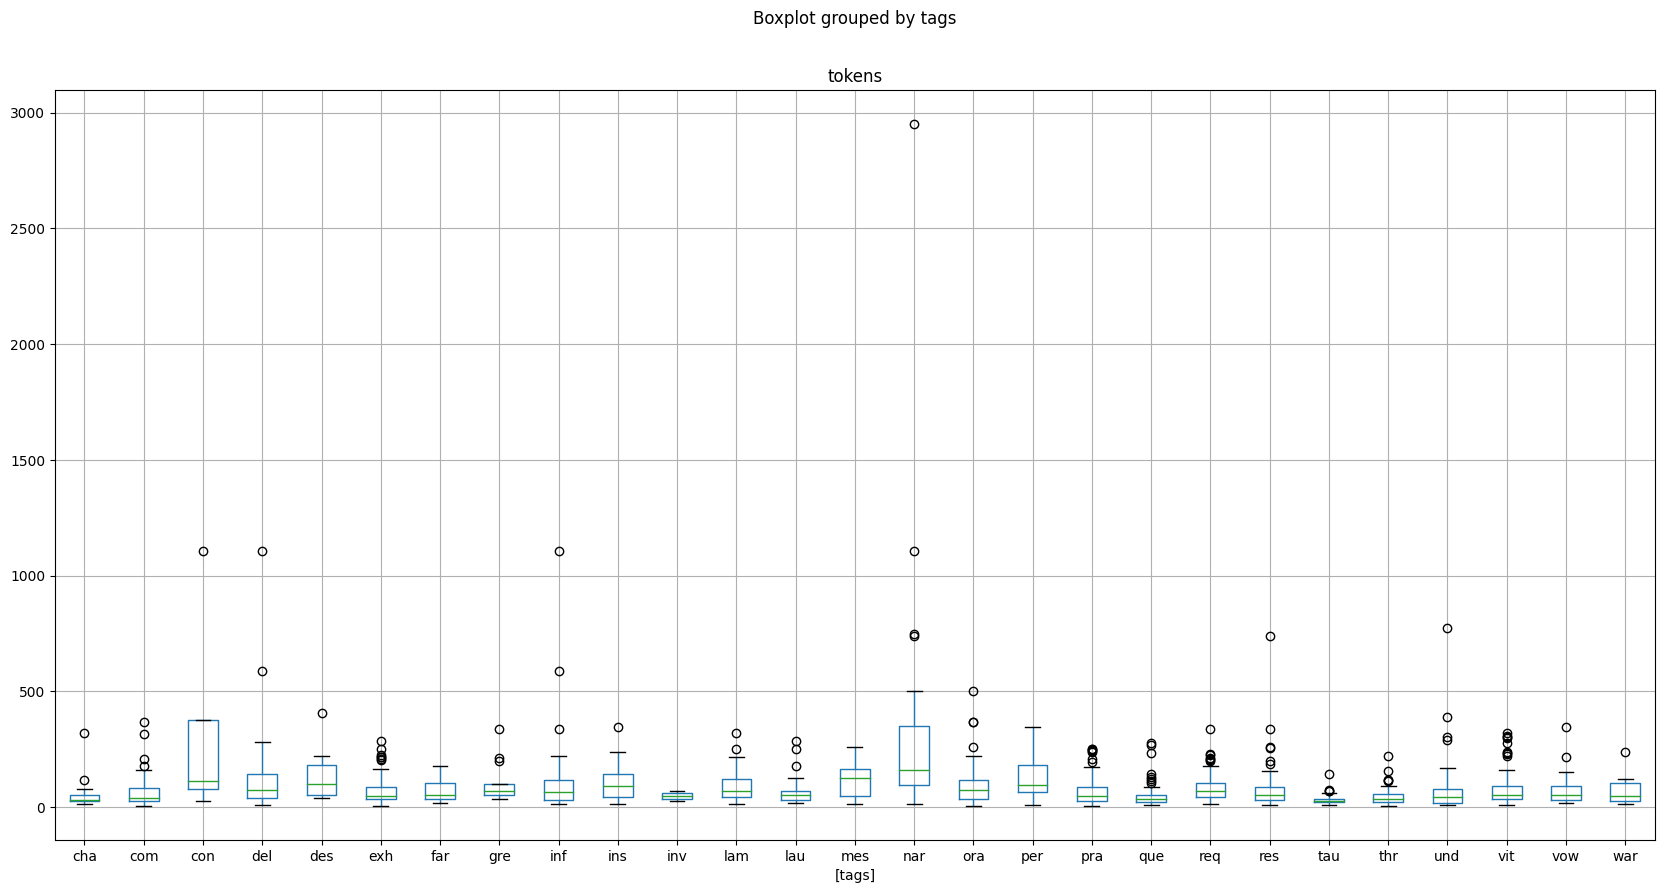

In [26]:
# summarize each speech by number of tokens and tags
x = flav_tokens.groupby('id').agg(
    tokens = ('lem', 'count'),
    tags = ('tags', 'first'),
)
x = x.explode('tags')
x.boxplot(by='tags', figsize=(20,10))
plt.show()

A few outliers are making the plot hard to read. Let's zoom in on speeches of 500 tokens or fewer.

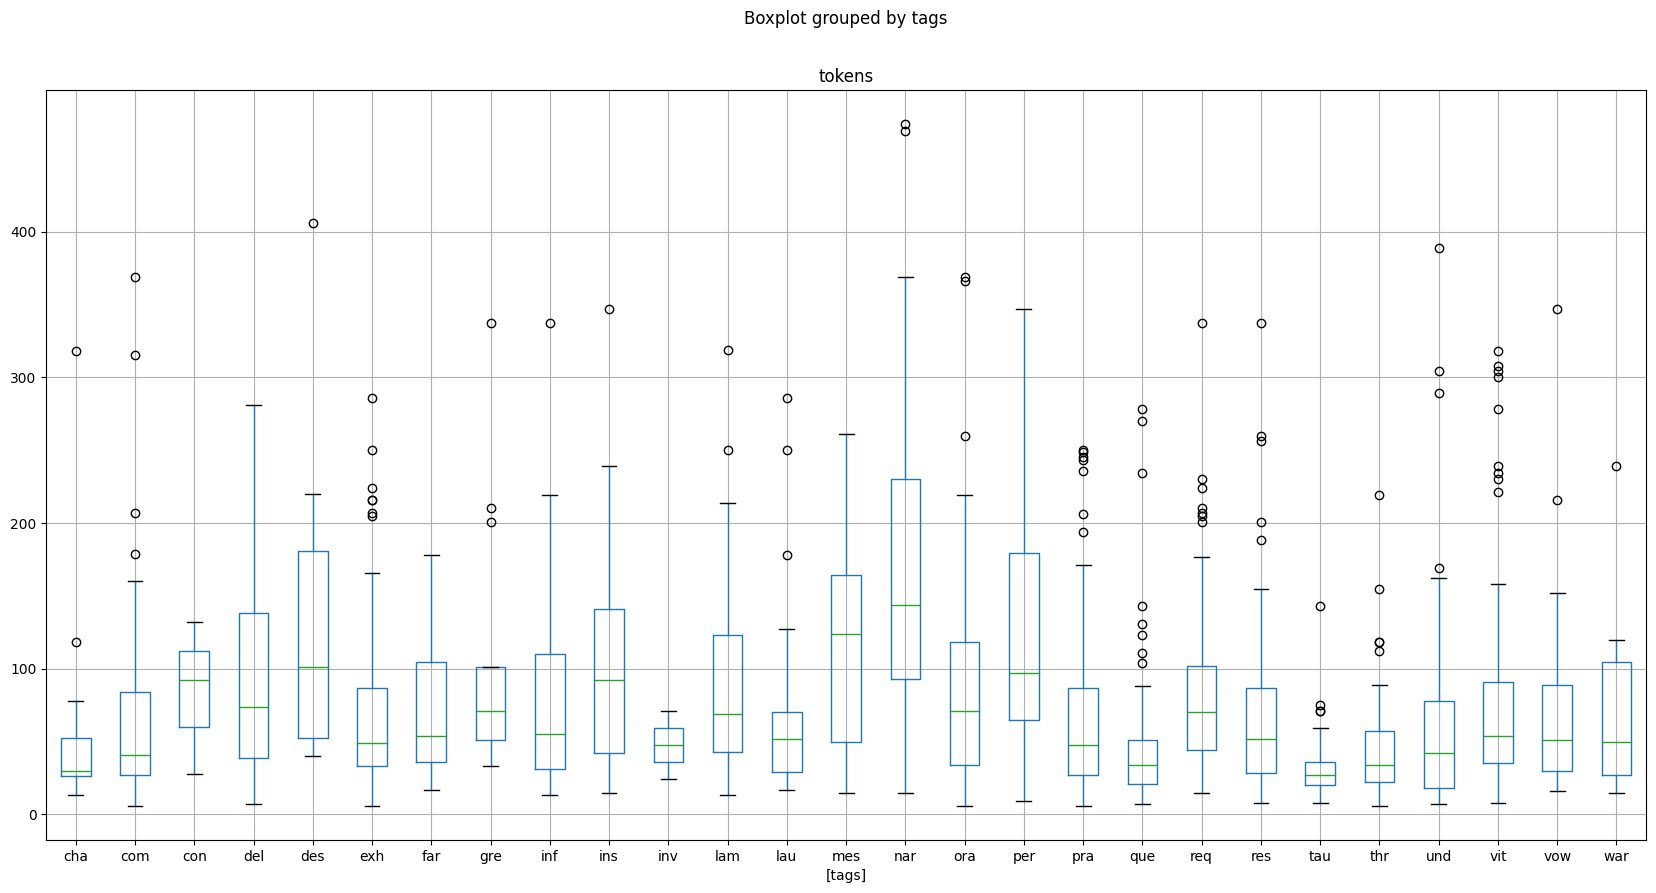

In [27]:
x[x.tokens < 500].boxplot(by='tags', figsize=(20,10))
plt.show()

It's not a surprise that, on average, narrative speeches are the longest.


### Calculate POS feature vectors for speeches

As we did above for Seneca, here we tally part of speech counts for all the Flavians' speeches.

#### Raw counts

In [28]:
flav_pos = pd.crosstab(flav_tokens.id, flav_tokens.pos)
flav_pos

pos,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB,X
id,,,,,,,,,,,,,,,
2499,14,1,6,0,7,7,45,1,1,12,1,7,3,19,0
2500,3,3,1,0,5,0,26,0,0,7,0,2,3,19,0
2501,3,1,7,3,5,4,15,0,1,4,0,2,0,8,0
2502,4,4,2,0,2,2,15,0,1,2,0,4,0,9,0
2503,3,3,5,2,6,2,24,0,1,6,0,4,4,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,4,3,4,1,4,4,23,0,0,5,1,3,3,20,0
3310,6,0,3,0,1,0,13,0,0,5,0,0,1,7,0
3311,22,11,10,1,14,8,81,0,2,6,4,8,5,47,0


#### Normalized by speech



In [29]:
flav_norm = pd.crosstab(flav_tokens.id, flav_tokens.pos, normalize='index')
flav_norm

pos,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB,X
id,,,,,,,,,,,,,,,
2499,0.112903,0.008065,0.048387,0.000000,0.056452,0.056452,0.362903,0.008065,0.008065,0.096774,0.008065,0.056452,0.024194,0.153226,0.0
2500,0.043478,0.043478,0.014493,0.000000,0.072464,0.000000,0.376812,0.000000,0.000000,0.101449,0.000000,0.028986,0.043478,0.275362,0.0
2501,0.056604,0.018868,0.132075,0.056604,0.094340,0.075472,0.283019,0.000000,0.018868,0.075472,0.000000,0.037736,0.000000,0.150943,0.0
2502,0.088889,0.088889,0.044444,0.000000,0.044444,0.044444,0.333333,0.000000,0.022222,0.044444,0.000000,0.088889,0.000000,0.200000,0.0
2503,0.039474,0.039474,0.065789,0.026316,0.078947,0.026316,0.315789,0.000000,0.013158,0.078947,0.000000,0.052632,0.052632,0.210526,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,0.053333,0.040000,0.053333,0.013333,0.053333,0.053333,0.306667,0.000000,0.000000,0.066667,0.013333,0.040000,0.040000,0.266667,0.0
3310,0.166667,0.000000,0.083333,0.000000,0.027778,0.000000,0.361111,0.000000,0.000000,0.138889,0.000000,0.000000,0.027778,0.194444,0.0
3311,0.100457,0.050228,0.045662,0.004566,0.063927,0.036530,0.369863,0.000000,0.009132,0.027397,0.018265,0.036530,0.022831,0.214612,0.0


### Distribution of POS tags by speech type

Here we examine visually whether the proportion of different parts of speech varies much between speech types.

First, collect the speech metadata we might use to compare speeches.

In [30]:
flav_labels = flav_tokens.groupby('id').agg({'auth':'first', 'spkr':'first', 'tags':'first'})

#### Build a table with one row per tag

We start with the normalized POS features above, but speeches with multiple types are broken out into multiple (duplicate) rows.

In [31]:
x = pd.concat([flav_norm, flav_labels.tags], axis=1)
x = x.explode('tags')

#### Draw some box plots

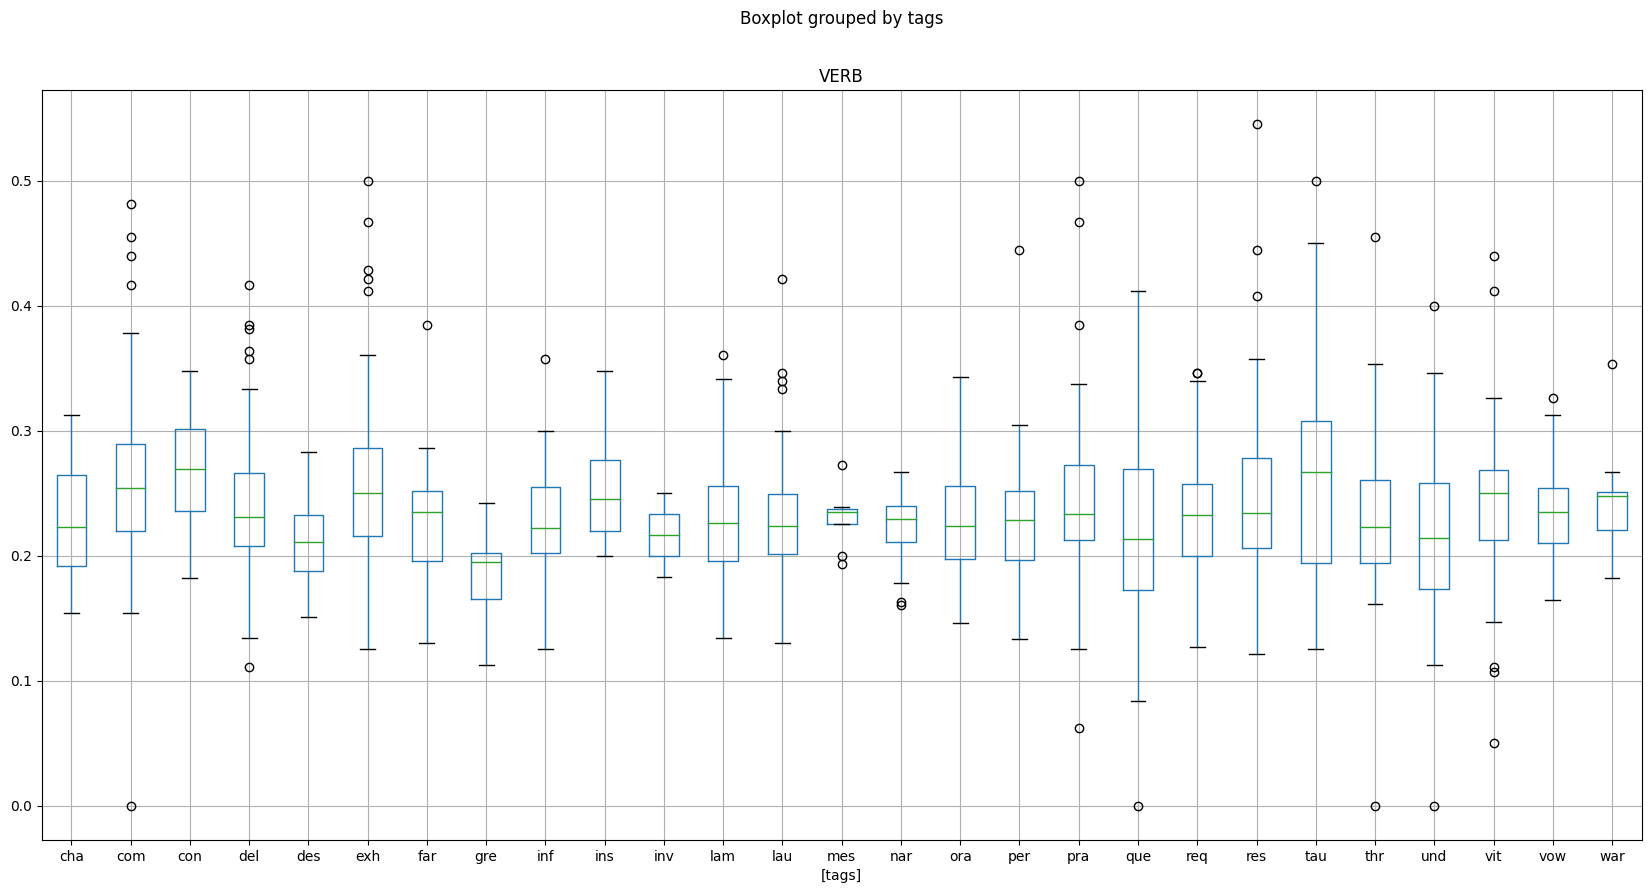

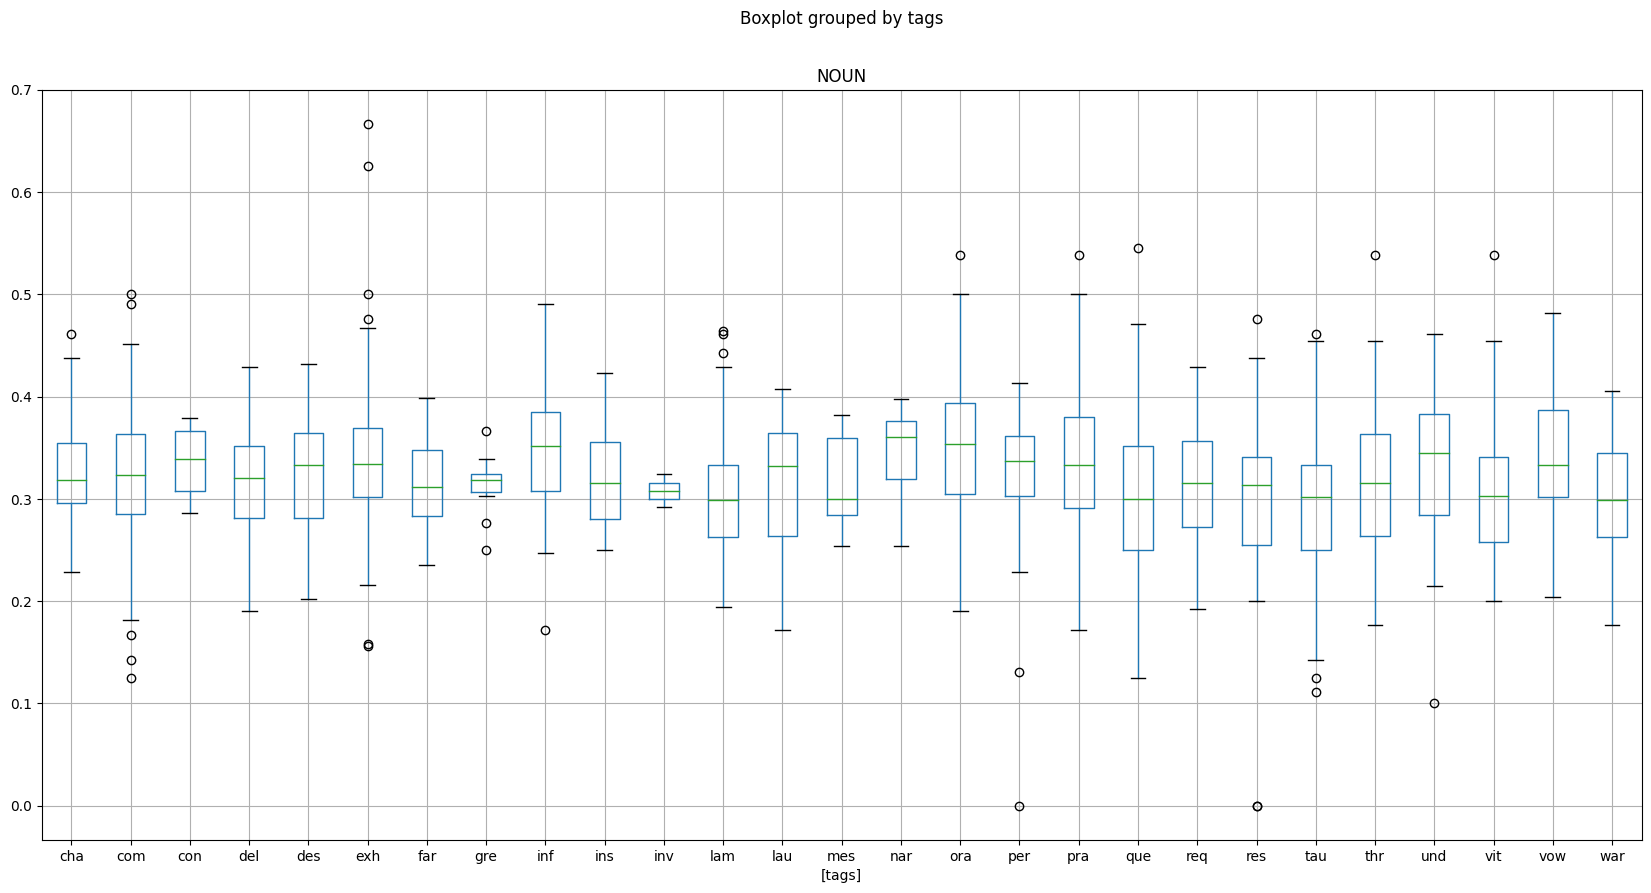

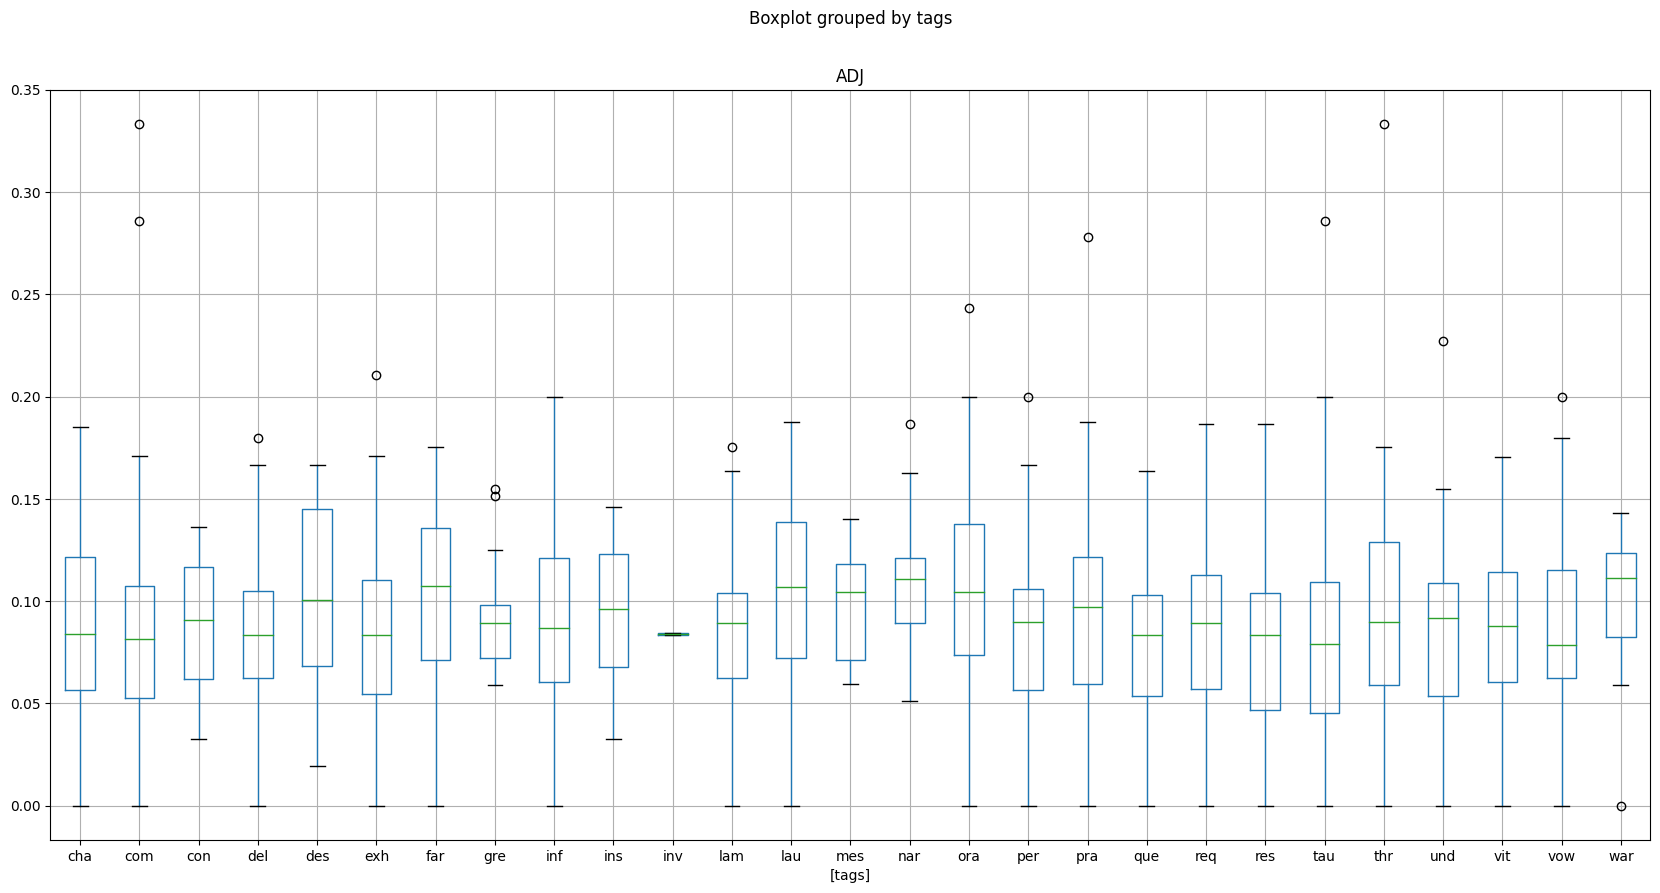

In [32]:
for feat in ['VERB', 'NOUN', 'ADJ']:
    x[[feat, 'tags']].boxplot(by='tags', figsize=(20,10))
plt.show()

# Part 3: Comparison

First, join the Seneca and Flavians tables.

In [33]:
all_tokens = pd.concat([sen_tokens, flav_tokens], ignore_index=True)
all_labels = pd.concat([sen_labels, flav_labels])
all_pos = pd.concat([sen_norm, flav_norm], ignore_index=True).set_index(all_labels.index)
all_pos = all_pos.fillna(0)

### Calculate PCA features

Instead of using individual POS tags, we can create a more holistic featureset using principal components analysis. Each of the resulting features incorporates elements of all the POS parameters.

In [34]:
pca_model = PCA(n_components=3)
pca_features = pca_model.fit_transform(all_pos)
all_pca = pd.DataFrame(
    index=all_pos.index,
    data=pca_features, 
    columns=['PC1', 'PC2', 'PC3'])
all_pca

,PC1,PC2,PC3
id,,,
0,-0.014468,-0.034897,-0.028484
1,0.041409,0.019589,-0.029546
2,0.002129,-0.002682,-0.070020
3,0.019784,-0.050047,-0.095519
4,-0.070205,-0.006008,0.002031
...,...,...,...
3309,0.027212,-0.024067,0.005674
3310,-0.053812,0.053924,-0.025995
3311,-0.068443,-0.017323,-0.025188


### Visualize

Let's plot all the speeches according to the first two principal components, grouped by author. We might expect that if the authors have very different syntactic styles, we could see a noticeable difference between the clouds of coloured dots.

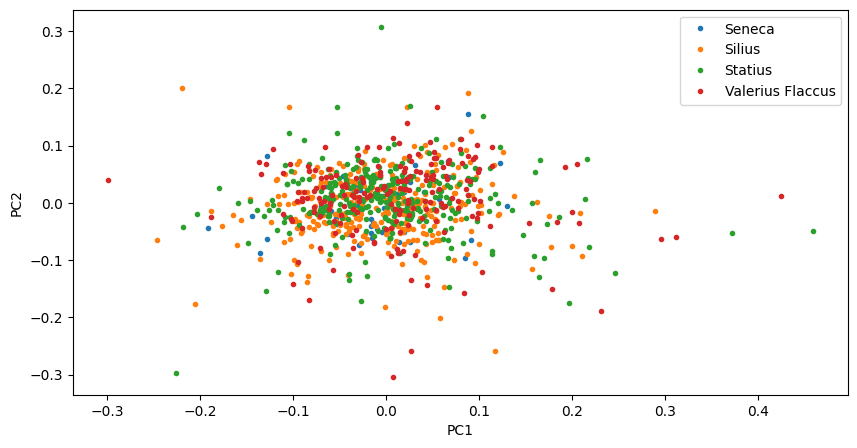

In [35]:
groups = all_pca.groupby(all_labels.auth.values)

feat_x = 'PC1'
feat_y = 'PC2'

fig, ax = plt.subplots(figsize=(10,5))
for name, group in groups:
    ax.plot(group[[feat_x]], group[[feat_y]], marker='o', linestyle='', ms=3, label=name)
ax.set_xlabel(feat_x)
ax.set_ylabel(feat_y)
ax.legend()

plt.show()


For my part,  I don't think I see any interesting separation between the groups, which suggests that the primary stylistic difference between these speeches is elsewhere.

### PCA features by type tag

This series of plots shows one speech type at a time, according to the first two principal components:

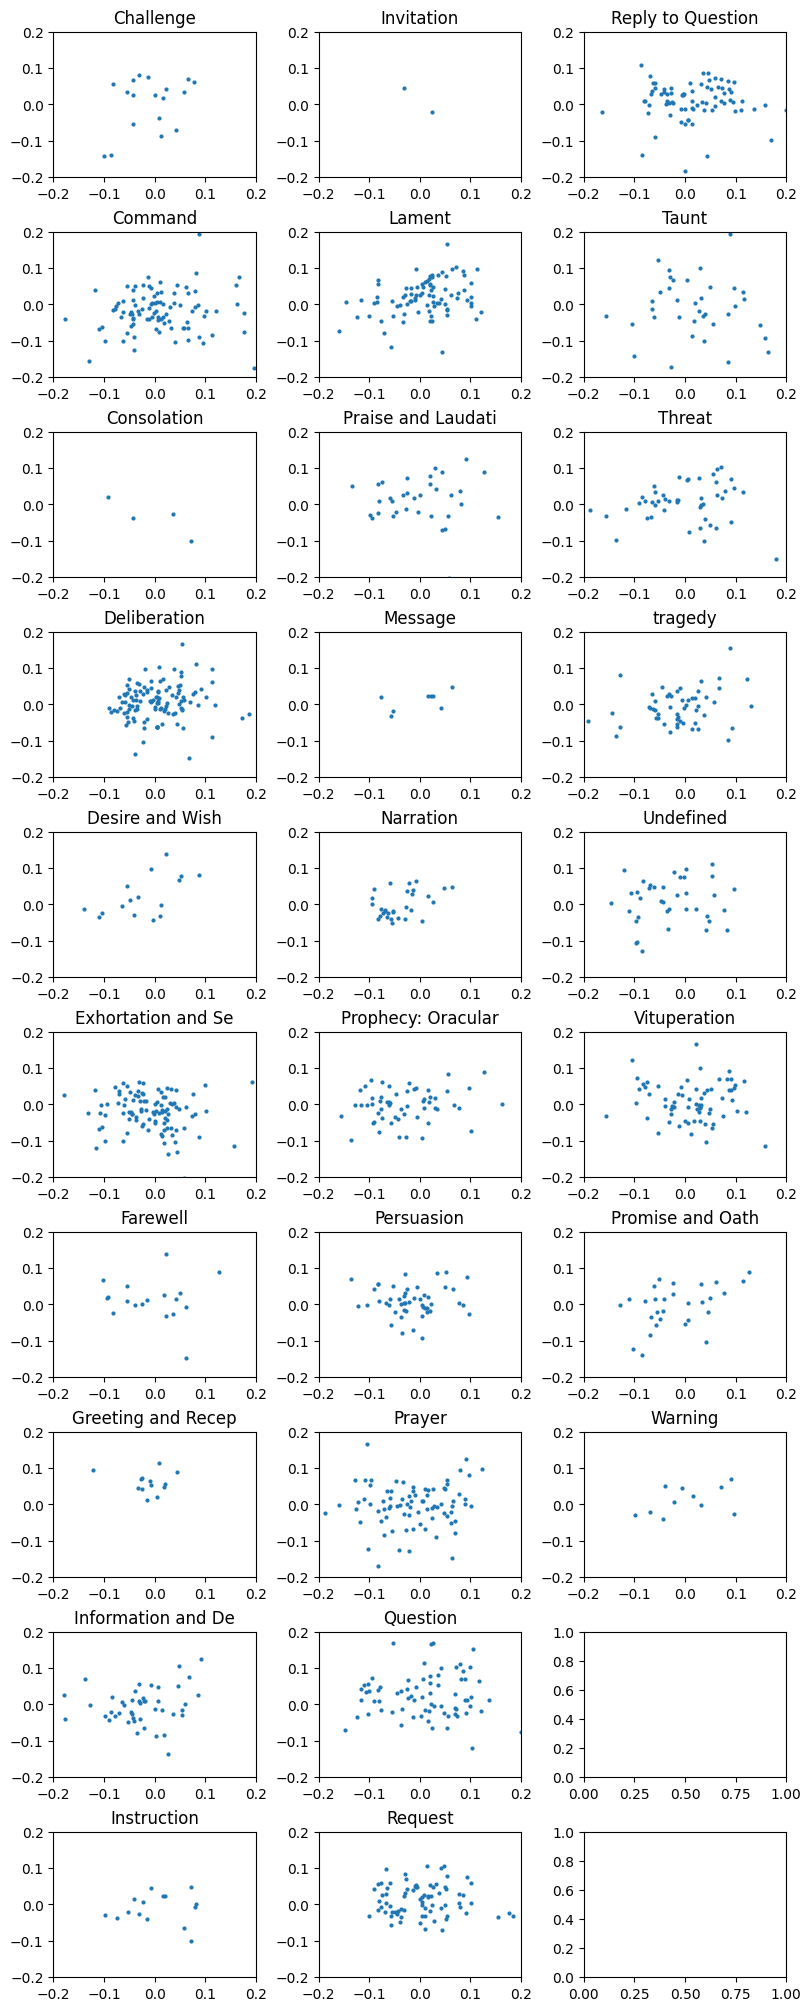

In [36]:
x = pd.concat([all_pca, all_labels.tags], axis=1).explode('tags')

groups = x.groupby('tags')

ncols = 3
nrows = math.ceil(len(groups)/ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(8,20), layout='constrained')

i = 0
j = 0
for name, group in groups:
    ax = axs[i, j]
    ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=2, label=name)
    ax.set_xlim((-0.2, 0.2))
    ax.set_ylim((-0.2, 0.2))
    ax.set_title(tagtype[name][:18])
    i = i + 1
    if i >= nrows:
        i = 0
        j = j + 1
plt.show()

It would have been cool if some types of speeches were more like Seneca than others, but I don't think I see a big difference here.

The one thing that stands out visually is a separation between instructions and greetings. Let's take a closer look at that, just for fun:

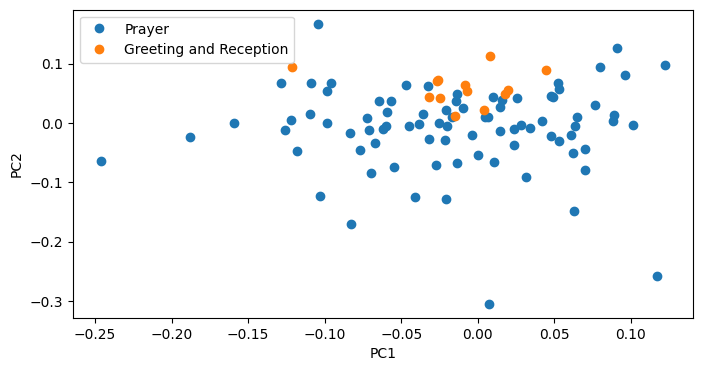

In [37]:
x_feat = 'PC1'
y_feat = 'PC2'
names = ['pra', 'gre']

fig, ax = plt.subplots(figsize=(8,4))
for name in names:
    ax.plot(x.loc[x.tags==name][x_feat], x.loc[x.tags==name][y_feat], marker='o', linestyle='', label=tagtype[name])
    ax.set_xlabel(x_feat)
    ax.set_ylabel(y_feat)
ax.legend()
plt.show()

## Lemma-based features

Putting aside POS tags, let's look at specific lemmata for our features.

**Feature selection**

We have the option of hand-selecting a feature set---that is, a bundle of lemmata that we care about. One trick is that word frequency declines exponentially, so the number of samples containing a given word declines very rapidly as we look at less frequent words. If the words we choose aren't in the samples, then they're not useful in measuring how the samples compare to one another.

### Lemma counts

Let's begin by creating a tally of how often each lemma occurs. 

In [38]:
all_tokens

,id,auth,tags,l_fi,l_la,spkr,lem,pos,work
0,0,Seneca,trag,1.000,278.000,Iuno,Soror,NOUN,NaN
1,0,Seneca,trag,1.000,278.000,Iuno,Tonantis,VERB,NaN
2,0,Seneca,trag,1.000,278.000,Iuno,(,PUNCT,NaN
3,0,Seneca,trag,1.000,278.000,Iuno,hic,PRON,NaN
4,0,Seneca,trag,1.000,278.000,Iuno,enim,ADV,NaN
...,...,...,...,...,...,...,...,...,...
73909,2691,Valerius Flaccus,"[res, per]",8.467,8.467,[Jason],?,PUNCT,Argonautica
73910,2691,Valerius Flaccus,"[res, per]",8.467,8.467,[Jason],ego,PRON,Argonautica
73911,2691,Valerius Flaccus,"[res, per]",8.467,8.467,[Jason],talis,DET,Argonautica
73912,2691,Valerius Flaccus,"[res, per]",8.467,8.467,[Jason],velle,VERB,Argonautica


In [39]:
# omit punctuation
mask = all_tokens.pos != 'PUNCT'

lem_count = all_tokens[mask].groupby('lem').agg(
    tokens = pd.NamedAgg(column='id', aggfunc='count'),
    speeches = pd.NamedAgg(column='id', aggfunc='nunique'),
).sort_values(by='tokens', ascending=False)
lem_count[:50]

,tokens,speeches
lem,,
et,1904,590
qui,1113,473
hic,1093,512
tu,911,401
ego,879,403
sum,813,414
in,730,366
non,539,304
nec,530,292


### An example featureset 

I've hand-selected some of the most frequent words here. You can replace these with anything you want and try it out.

In [40]:
keywords = [
    'et', 'qui', 'hic', 'tu', 'ego', 'sum', 'in', 'non', 'nec', 'atque', 
    'do', 'ille', 'noster', 'si', 'iam', 'ad', 'quis', 'nunc', 'tuus', 
    'ipse', 'sed', 'meus', 'fero', 'per', 'magnus', 'bellum', 'deus', 
    'cum', 'aut', 'manus', 'pater', 'o', 'nos', 'omnis', 'arma', 'sic',
    'ab', 'ut', 'ago', 'nascor', 'dexter', 'sanguis', 'labor', 'terra', 
    'facio', 'eo', 'primus', 'aio', 'gens',
]

### Feature extraction

Let's extract the lemma frequencies for each speech, considering only these features.

#### A table of feature vectors

The resulting table has one row per speech, and one column for each of the lemmata in our featureset. The speech is  represented by *n* feature frequencies, so we can think of it as a point, or vector, in an *n*-dimensional space.

In [41]:
all_vec = pd.crosstab(all_tokens.id, all_tokens.lem, normalize='index')

In [42]:
x = all_vec.loc[:, keywords]

**Now add the tag data**

In order to compare between speech types, we're going to add in a tag column. Then as we did above, we have to break out any rows with multiple tags. 

In [43]:
x['tags'] = all_labels.tags
x = x.explode('tags')
x

lem,et,qui,hic,tu,ego,sum,in,non,nec,atque,...,dexter,sanguis,labor,terra,facio,eo,primus,aio,gens,tags
id,,,,,,,,,,,,,,,,,,,,,
0,0.026428,0.017903,0.006820,0.000853,0.011083,0.015345,0.007673,0.005968,0.005115,0.008525,...,0.000000,0.000853,0.004263,0.00341,0.007673,0.000000,0.001705,0.0,0.001705,trag
1,0.033520,0.011173,0.000000,0.050279,0.005587,0.016760,0.000000,0.000000,0.011173,0.005587,...,0.005587,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,trag
2,0.012658,0.006329,0.000000,0.006329,0.006329,0.031646,0.012658,0.018987,0.006329,0.012658,...,0.000000,0.000000,0.000000,0.00000,0.012658,0.000000,0.006329,0.0,0.000000,trag
3,0.000000,0.000000,0.013514,0.000000,0.000000,0.013514,0.000000,0.000000,0.013514,0.000000,...,0.013514,0.000000,0.000000,0.00000,0.013514,0.000000,0.000000,0.0,0.013514,trag
4,0.018868,0.006289,0.006289,0.012579,0.012579,0.025157,0.006289,0.000000,0.000000,0.012579,...,0.000000,0.006289,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,trag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,0.040000,0.066667,0.013333,0.000000,0.000000,0.013333,0.040000,0.000000,0.013333,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,del
3310,0.027778,0.027778,0.027778,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,del
3311,0.041096,0.000000,0.009132,0.000000,0.000000,0.009132,0.009132,0.009132,0.009132,0.004566,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,nar


**Example: how does use of *sum* vary across speech types?**

Answer: not much. But compare, for example, consolation (`con`) and challenge (`cha`).

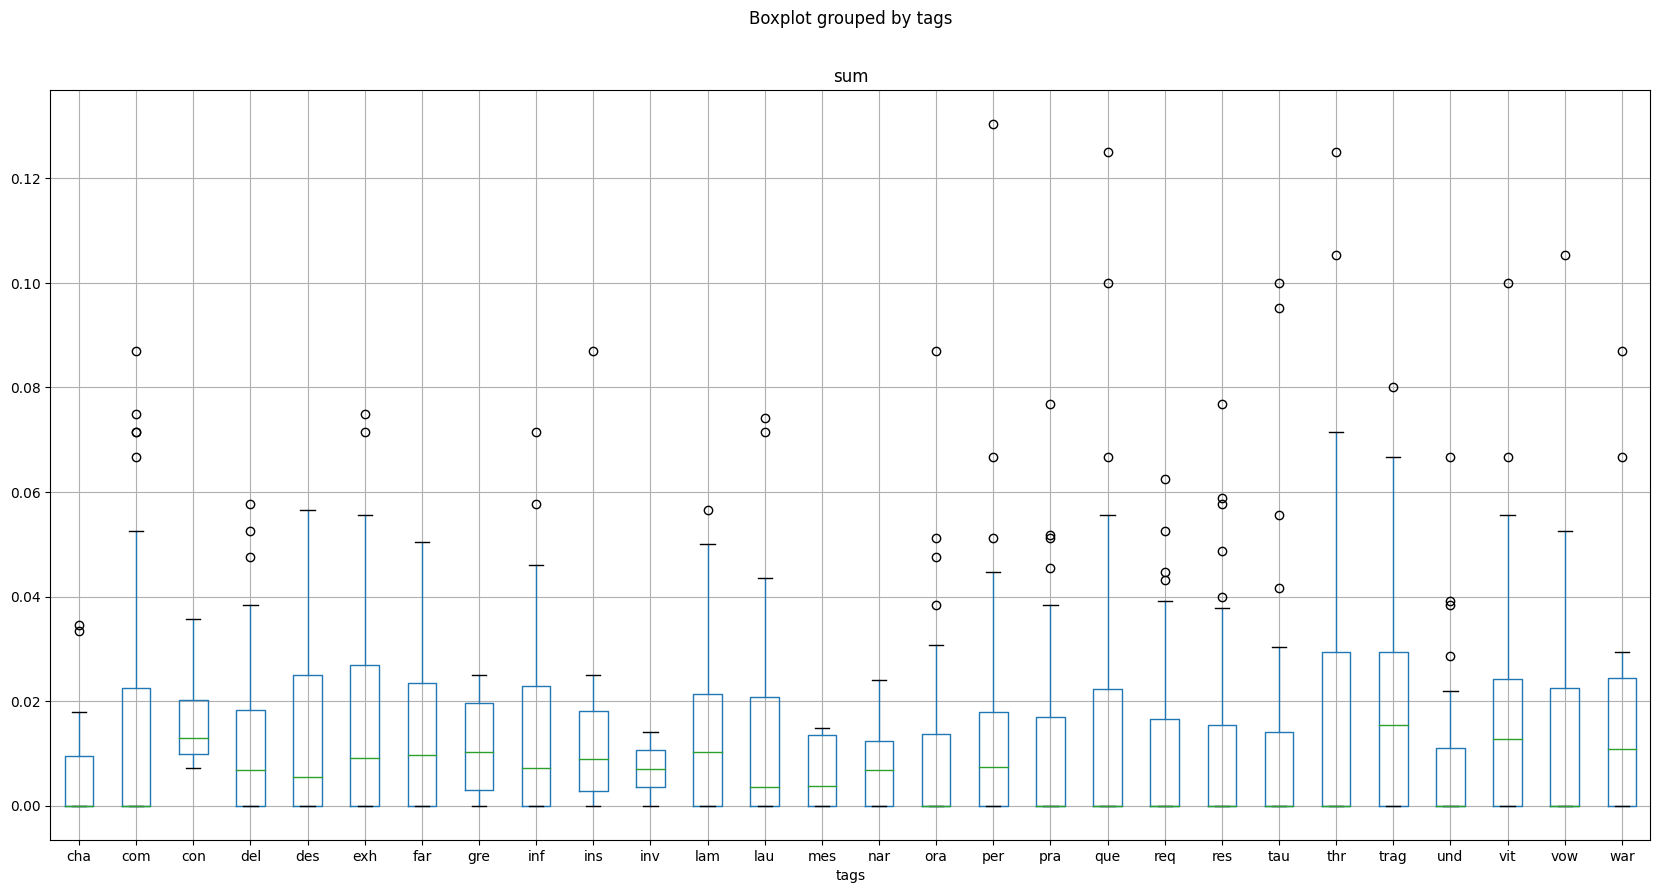

In [44]:
x.boxplot(column='sum', by='tags', figsize=(20,10))
plt.show()

### Log frequencies

The distributions of lemmata are not normal across these samples, because of the exponential rate of decrease mentioned above. That's one reason why so many of the boxes in the plot above have a really low mean but then a bunch of outliers at the top. 

If we consider not the frequencies but the log of the frequencies, it's a little easier to see the variation. Any samples where a given word does not occur will have a frequency of `0`; in the log version we'll replace that with the placeholder value `NaN`, since the log of 0 can't be calculated.

In [45]:
x_log = x.copy()
for col in x_log.columns:
    if col != 'tags':
        x_log[col] = x[col].apply(np.log).values
x_log[x==0] = np.nan
x_log

lem,et,qui,hic,tu,ego,sum,in,non,nec,atque,...,dexter,sanguis,labor,terra,facio,eo,primus,aio,gens,tags
id,,,,,,,,,,,,,,,,,,,,,
0,-3.633333,-4.022797,-4.987878,-7.067320,-4.502370,-4.176948,-4.870095,-5.121410,-5.275560,-4.764735,...,NaN,-7.067320,-5.457882,-5.681025,-4.870095,NaN,-6.374173,NaN,-6.374173,trag
1,-3.395626,-4.494239,NaN,-2.990161,-5.187386,-4.088774,NaN,NaN,-4.494239,-5.187386,...,-5.187386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trag
2,-4.369448,-5.062595,NaN,-5.062595,-5.062595,-3.453157,-4.369448,-3.963983,-5.062595,-4.369448,...,NaN,NaN,NaN,NaN,-4.369448,NaN,-5.062595,NaN,NaN,trag
3,NaN,NaN,-4.304065,NaN,NaN,-4.304065,NaN,NaN,-4.304065,NaN,...,-4.304065,NaN,NaN,NaN,-4.304065,NaN,NaN,NaN,-4.304065,trag
4,-3.970292,-5.068904,-5.068904,-4.375757,-4.375757,-3.682610,-5.068904,NaN,NaN,-4.375757,...,NaN,-5.068904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,-3.218876,-2.708050,-4.317488,NaN,NaN,-4.317488,-3.218876,NaN,-4.317488,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,del
3310,-3.583519,-3.583519,-3.583519,-3.583519,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,del
3311,-3.191847,NaN,-4.695925,NaN,NaN,-4.695925,-4.695925,-4.695925,-4.695925,-5.389072,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nar


### Comparing log lemma frequencies between speech types

We already know that our main interest in terms of speech types is oracular speech. Let's see how it compares with other speech types using the new featureset.

#### Visualizing with boxplots

Here we compare a couple of our features across oracular speech, taunts and challenges.

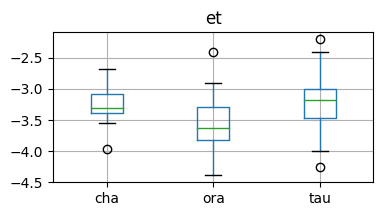

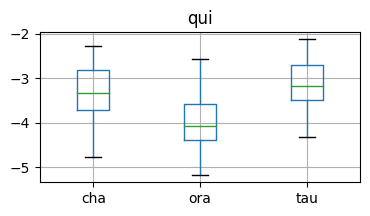

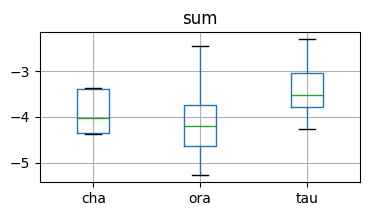

In [46]:
features = ['et', 'qui', 'sum']
row_select = ['ora', 'tau', 'cha']

for feat in features:
    mask = x_log.tags.isin(row_select) 
    x_log[mask].boxplot(column=feat, by='tags', figsize=(4,2))
    plt.suptitle('')
    plt.xlabel('')
    plt.show()

#### Visualizing with histograms

Here's a comparison of the distribution of *et* in oracular speech versus in the "taunt" and "challenge" categories combined.

The distributions overlap, but the taunt/challenge group tends to use *et* more frequently.

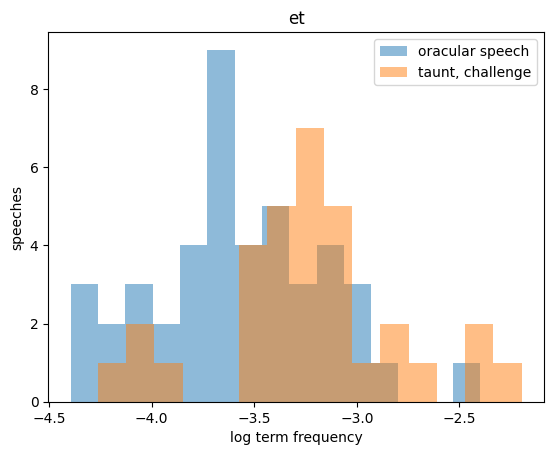

In [47]:
feat = 'et'
label = 'oracular speech'
comp_mask = (x_log.tags=='tau')|(x_log.tags=='cha')
comp_label = 'taunt, challenge'

fig, ax = plt.subplots()
ax.hist(x_log[x_log.tags=='ora'][feat], bins=15, alpha=0.5, label=label)
ax.hist(x_log[comp_mask][feat], bins=15, alpha=0.5, label=comp_label)
ax.legend()
ax.set_title(feat)
ax.set_xlabel('log term frequency')
ax.set_ylabel('speeches')
plt.show()

**Visualizing as a 2d feature-space**

We can also plot each speech as a point in a cartesian space defined by two features. For example, here we look at the log frequencies of 'et' and 'hic'.

Now we're starting to see some separation...

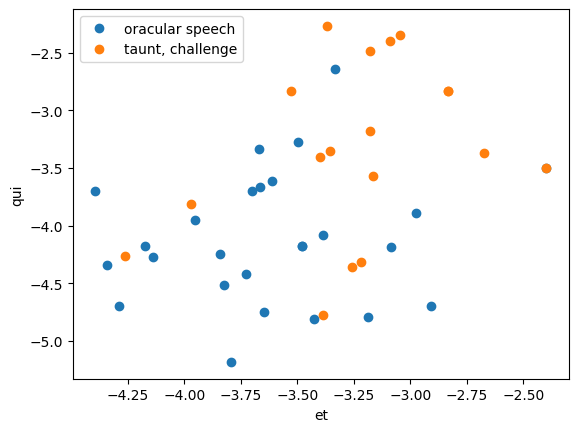

In [48]:
feat_x = 'et'
feat_y = 'qui'

comp_label = 'taunt, challenge'
comp_mask = x_log.tags.isin(['cha', 'tau'])

targ_label = 'oracular speech'
targ_mask = x_log.tags == 'ora'

fig, ax = plt.subplots()
ax.plot(x_log[targ_mask][feat_x], x_log[targ_mask][feat_y], marker='o', linestyle='', label=targ_label)
ax.plot(x_log[comp_mask][feat_x], x_log[comp_mask][feat_y], marker='o', linestyle='', label=comp_label)
ax.set_xlabel(feat_x)
ax.set_ylabel(feat_y)
ax.legend()
plt.show()

### Speech-type "averages"

This chart averages token frequencies by tag, showing the hypothetical "centre" for each speech type. By aggregating all the speeches we can get better readings for less-frequent words. But remember the messiness and overlap of the clouds we saw above, and take the apparent differences between tags here with a grain of salt.

In [49]:
foo = all_tokens.explode('tags')
foo = foo.loc[foo.pos != 'PUNCT']
tag_norm = pd.crosstab(foo.tags, foo.lem, normalize='index')

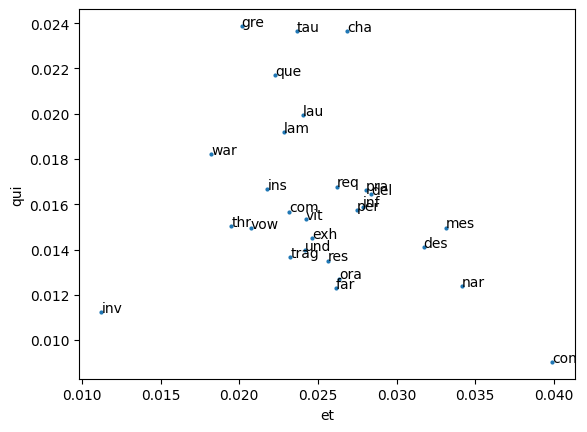

In [50]:
feat_x = 'et'
feat_y = 'qui'

fig, ax = plt.subplots()
ax.plot(tag_norm[feat_x], tag_norm[feat_y], marker='o', linestyle='', ms=2)
for x, y, s in zip(tag_norm[feat_x], tag_norm[feat_y], tag_norm.index):
    ax.text(x,y,s)
ax.set_xlabel(feat_x)
ax.set_ylabel(feat_y)
plt.show()

### Simplifying with PCA

As above, we can use PCA to simplify our feature set to a few, composite features that each comprise a combination of different lemma frequencies.

In [51]:
foo = tag_norm.loc[tag_norm.index != 'inv']
pca_model = PCA(n_components=3)
tag_pca = pca_model.fit_transform(foo)
tag_pca = pd.DataFrame(
    data=tag_pca,
    columns=['PC1', 'PC2', 'PC3'],
    index=tag_norm.index[tag_norm.index!='inv'])
tag_pca

,PC1,PC2,PC3
tags,,,
cha,-0.011120,-0.018765,0.014841
com,0.000321,0.003307,-0.000090
con,0.036098,-0.003205,-0.005372
del,0.000936,-0.003967,0.001334
des,0.007045,-0.008541,0.006146
exh,0.002315,0.001691,-0.000446
far,-0.005026,0.001352,-0.013147
gre,-0.016259,-0.003640,-0.016051
inf,0.009707,-0.001968,0.002262


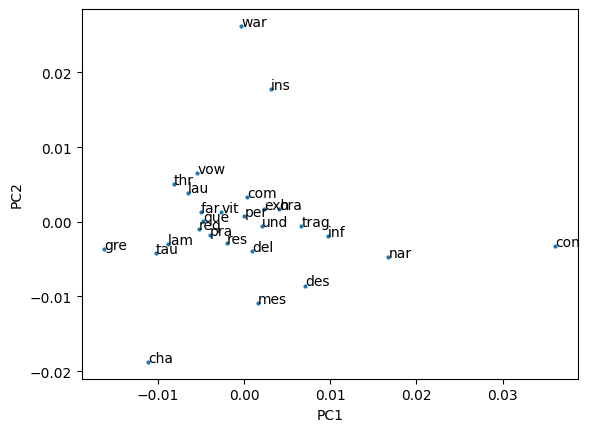

In [52]:
feat_x = 'PC1'
feat_y = 'PC2'

fig, ax = plt.subplots()
ax.plot(tag_pca[feat_x], tag_pca[feat_y], marker='o', linestyle='', ms=2)
for x, y, s in zip(tag_pca[feat_x], tag_pca[feat_y], tag_pca.index):
    ax.text(x,y,s)
ax.set_xlabel(feat_x)
ax.set_ylabel(feat_y)
plt.show()

After PCA, the units on this graph don't really mean much, but the relative distances between the points tell us something about the degree of overlap between the tags in terms of diction. This suggests that warnings (`war`) are quite different from challenges (`cha`), and greetings (`gre`) from consolations (`con`). Meanwhile, oracular speech (`ora`) and tragedy (`trag`) are relatively closely situated, right in the centre.

## Which tokens are most distinctive?

This is one way to surface potentially interesting words for the types under consideration. Following [an example](https://www.humanitiesdataanalysis.org/introduction-cook-books/notebook.html#taste-trends-in-culinary-us-history) in Chapter 1 of Karsdorp, Kestemont and Riddel's [Humanities Data Analysis](https://www.humanitiesdataanalysis.org), we use scikit-learn's `chi2` to measure "keyness" of individual features between categories.

### Narrowing the feature set

Let's limit our investigation to lemmata that occur in at least 10 speeches.

In [53]:
keywords = lem_count.index[lem_count.speeches>=10].values

### Create a document-term matrix

This is a table with one row per speech *per type*, one column for each lemma whose frequency we want to consider.  It's based on the giant table of all lemma frequencies, but limited to the narrower set of lemmata chosen above, and then speeches assigned to multiple types are broken out into multiple rows.

In [54]:
x = pd.concat([all_vec.loc[:,keywords], all_labels.tags], axis=1)
x = x.explode('tags')
labels = x.tags
x = x.drop('tags', axis=1)
x

,et,qui,hic,tu,ego,sum,in,non,nec,atque,...,humanus,fiducia,iuvet,coeo,nequiquam,iux,Tyrio,igneus,fecundus,anneo
id,,,,,,,,,,,,,,,,,,,,,
0,0.026428,0.017903,0.006820,0.000853,0.011083,0.015345,0.007673,0.005968,0.005115,0.008525,...,0.000853,0.0,0.000853,0.000000,0.0,0.000853,0.0,0.000853,0.000853,0.0
1,0.033520,0.011173,0.000000,0.050279,0.005587,0.016760,0.000000,0.000000,0.011173,0.005587,...,0.000000,0.0,0.000000,0.000000,0.0,0.005587,0.0,0.000000,0.000000,0.0
2,0.012658,0.006329,0.000000,0.006329,0.006329,0.031646,0.012658,0.018987,0.006329,0.012658,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.013514,0.000000,0.000000,0.013514,0.000000,0.000000,0.013514,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
4,0.018868,0.006289,0.006289,0.012579,0.012579,0.025157,0.006289,0.000000,0.000000,0.012579,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,0.040000,0.066667,0.013333,0.000000,0.000000,0.013333,0.040000,0.000000,0.013333,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
3310,0.027778,0.027778,0.027778,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
3311,0.041096,0.000000,0.009132,0.000000,0.000000,0.009132,0.009132,0.009132,0.009132,0.004566,...,0.000000,0.0,0.000000,0.004566,0.0,0.000000,0.0,0.000000,0.000000,0.0


### Keyness across all speech types

Let's look at the top 50 terms that distinguish between types. The most prominent terms here are mostly lemmatization errors, things that are therefore infrequent in the corpus and so really stand out.

In [55]:
keyness, _ = chi2(x, labels)
keyness = pd.Series(keyness, index=x.columns).sort_values(ascending=False)
keyness[:50]

vero          7.334131
pons          4.419818
'             4.080548
excido        3.229961
ruor          3.040080
Tydeus        2.993882
Troiae        2.992917
ego           2.805374
canis         2.790442
fera          2.767236
propinquus    2.633643
hasta         2.552020
nusquam       2.503685
aio           2.410363
mox           2.401100
diva          2.398884
volucres      2.342659
moneo         2.341959
letus         2.321989
iter          2.276949
induo         2.169245
gradus        2.149934
vera          2.133927
habena        2.044555
inquam        1.979840
manis         1.926033
decus         1.914312
flumen        1.907144
actus         1.829851
pulgo         1.805504
sed           1.763560
atrus         1.751304
morior        1.736039
probo         1.728625
iaceo         1.696749
ignis         1.685891
eo            1.675379
recipio       1.657285
inanis        1.654607
simul         1.638981
compleo       1.633161
mareo         1.628828
huc           1.625890
uir        

### Oracular vs non-oracular

Let's simplify, and divide the corpus into just two categories: oracular and everything else. Now keyness should tell us what distinguishes the type we're interested in.

In [56]:
keyness, _ = chi2(x, labels=='ora')
keyness = pd.Series(keyness, index=x.columns).sort_values(ascending=False)
keyness[:50]

fluo         0.418735
nitor        0.415133
pendeo       0.378859
bellum       0.337753
fallax       0.327970
nomen        0.286014
coniunx      0.232321
quantum      0.228631
sons         0.220105
caneo        0.216830
trepido      0.213723
praeda       0.204456
olim         0.201551
cadido       0.194730
centum       0.193124
uenio        0.185340
do           0.183127
turbidus     0.180801
flamma       0.180607
fatis        0.180404
tunc         0.177652
capio        0.174150
Iuppiter     0.173679
cruor        0.170135
regna        0.168470
sed          0.162824
sacer        0.158290
saeculum     0.157749
funus        0.153426
manes        0.153139
cas          0.151692
umquam       0.149107
exclamo      0.145952
ultra        0.140267
currus       0.137312
fraternus    0.136782
quiesco      0.134525
dubius       0.132202
terra        0.129334
supero       0.127394
mus          0.126752
fatum        0.124350
'            0.123303
penas        0.119742
iamque       0.119634
careo     